In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [2]:
import seaborn as sns

In [33]:
from numpy import linalg as LA

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

23/02/02 16:21:22 WARN Utils: Your hostname, Chus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.19.195.69 instead (on interface en0)
23/02/02 16:21:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/02/02 16:21:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
def parseVector(line):
    return np.array([float(x) for x in line.split(" ")])

In [6]:
data = spark.read.text('data/data.txt').rdd.map(lambda x: x[0]).map(parseVector)
c1 = np.loadtxt('data/c1.txt', delimiter = ' ')
c2 = np.loadtxt('data/c2.txt', delimiter = ' ')

In [7]:
#function for ecluidian distance
def eludian_distance(a, b):
    return np.sum((a - b) ** 2)

In [44]:
#fucntion for manhattan distance
def manhattan_distance(a, b):
    return LA.norm(a - b, ord=1)
    # return np.sum(np.abs(a - b))

In [46]:
#function to parse vector
def parseVector(line):
    return np.array([float(x) for x in line.split(" ")])

In [47]:
#function for the closest centroid eludian distance or manhattan distance
def closest_centroid(point, centroids, distance):
    closest_i = -1
    closest_dist = float("+inf")
    for i in range(len(centroids)):
        temp_dist = distance(point, centroids[i])
        if temp_dist < closest_dist:
            closest_i = i
            closest_dist = temp_dist
    return closest_i, closest_dist

In [48]:
#function for kmeans that return the cost of each iteration
def kmeans(data, centroids, distance, max_iter):
    error_list = []
    for i in range(max_iter):
        #find the closest centroid for each point
        closest = data.map(lambda p: (closest_centroid(p, centroids, distance)[0], (p, 1, closest_centroid(p, centroids, distance)[1])))
        #calculate the new centroids
        pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
        newCentroids = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()
        #calculate the error
        error = closest.map(lambda p: distance(p[1][0], centroids[p[0]])).reduce(lambda x, y: x + y)
        #append to the error list
        error_list.append(error)
        #store the new centroids back to the old centroids
        for (k, v) in newCentroids:
            centroids[k] = v
    return error_list

In [12]:
#sanity check
kmeans(data, c1.copy(), eludian_distance, 20)[5]

460537847.98277014

In [49]:
kmeans(data, c1.copy(), manhattan_distance, 20)[5]

487664.6926267901

In [13]:
c1_euclidean = kmeans(data, c1.copy(), eludian_distance, 21)
c2_euclidean = kmeans(data, c2.copy(), eludian_distance, 21)

In [22]:
a = (c1_euclidean[0] - c1_euclidean[10]) / c1_euclidean[0]
b = (c2_euclidean[0] - c2_euclidean[10]) / c2_euclidean[0]
print ("The percentage of error reduction for c1 is: ", (a*100).round(3), "%")
print ("The percentage of error reduction for c2 is: ", (b*100).round(4), "%")

The percentage of error reduction for c1 is:  26.484 %
The percentage of error reduction for c2 is:  76.698 %


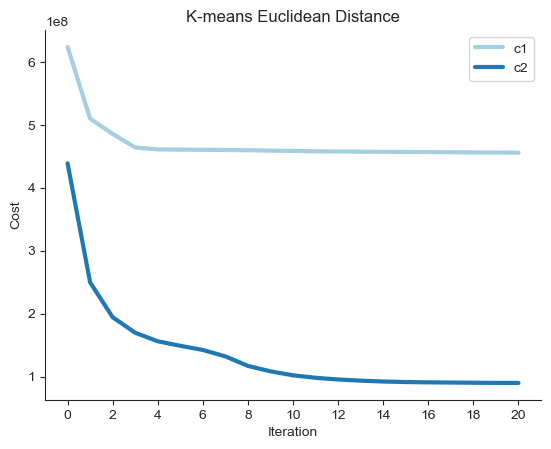

<Figure size 640x480 with 0 Axes>

In [187]:
#seaborn plot c1_euclidean and c2_euclidean
#seaborn style to white no grid
#seaborn change color palette to contrasting colors 2
sns.set_style("white")
sns.set_palette("Paired")
plt.plot(c1_euclidean, label = 'c1', linewidth = 3)
plt.plot(c2_euclidean, label = 'c2', linewidth = 3)
plt.xticks(np.arange(0, 21, 2))
plt.legend()
plt.xlabel('Iteration')
#hide the top and right spines
sns.despine()
# add ticks to the left and bottom spines
plt.tick_params(left = True, bottom = True)
plt.ylabel('Cost')
plt.title('K-means Euclidean Distance')
plt.show()
#save the plot, high resolution
plt.savefig('kmeans_euclidean.png', dpi = 300)


In [24]:
c1_manhattan = kmeans(data, c1.copy(), manhattan_distance, 21)
c2_manhattan = kmeans(data, c2.copy(), manhattan_distance, 21)

In [32]:
c1_manhattan[5]

487664.6926267901

In [29]:
c = (c1_manhattan[0] - c1_manhattan[10]) / c1_manhattan[0]
d = (c2_manhattan[0] - c2_manhattan[10]) / c2_manhattan[0]
print ("The percentage of error reduction for c1 is: ", (c*100).round(3), "%")
print ("The percentage of error reduction for c2 is: ", (d*100).round(3), "%")

The percentage of error reduction for c1 is:  18.655 %
The percentage of error reduction for c2 is:  51.554 %


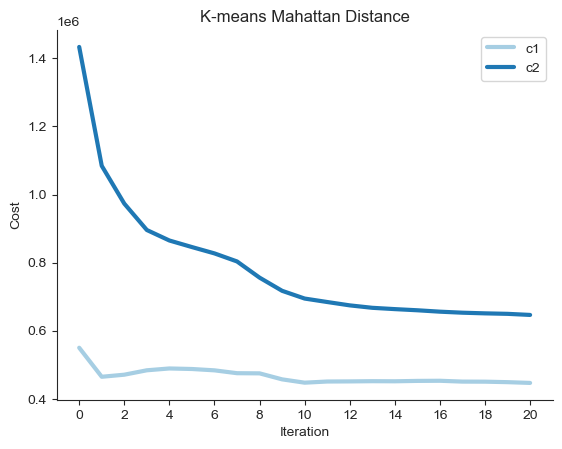

In [27]:
sns.set_style("white")
sns.set_palette("Paired")
plt.plot(c1_manhattan, label = 'c1', linewidth = 3)
plt.plot(c2_manhattan, label = 'c2', linewidth = 3)
#make x start from 0 and end at 22 with step 2
plt.xticks(np.arange(0, 21, 2))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('K-means Mahattan Distance')
# add ticks to the left and bottom spines
sns.despine()
plt.tick_params(left = True, bottom = True)
plt.show()
#save the plot, high resolution
#plt.savefig('kmeans_manhattan.png', dpi = 300)
